In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

from SALib.sample import saltelli,latin
import pandas as pd
import numpy as np

from scipy.interpolate import griddata


# Input Variables
# k (capital) 1-30 uniform, 1-15 uniform for random sample 
# θ (perceived shock factor) 0.1-1 uniform
# σ (risk averseness) normal centered around 1.08
# α (aptitude/human capital) normal centered around 1



In [2]:
# Generate Samples

# Saltelli Sample

n=8192
#N=5000
seed=1
#second order true n(2d+2)=n*10
#second order false n*(d+2)=n*6

problem={   "names": ["Alpha","k","Sigma","Theta"], 
            "num_vars":4,
            "bounds":[[1.08,0.074],[0.01,40],[0.01,2],[0.01,1]],
            "dists":["norm","unif","unif","unif"]}

S_sample=saltelli.sample(problem,n,calc_second_order=False)


S_sampledf=pd.DataFrame(S_sample, columns=["Alpha","k","Sigma","Theta"])

S_sampledf["Sigma"]=np.round(S_sampledf["Sigma"],1)
S_sampledf["Theta"]=np.round(S_sampledf["Theta"],1)
S_sampledf.index.name="AgentID"
# drop duplicates and samples with values of alpha and sigma < 0
S_sampledf=S_sampledf.drop_duplicates()
S_sampledf=S_sampledf[(S_sampledf["Alpha"]>=0) & (S_sampledf["Sigma"]>=0)]

S_sampledf.to_csv("AgentData-Updated30Oct2024.csv")

# # Latin Hypercube Sample
# LH_sample=latin.sample(problem,N,seed)

# LH_sampledf=pd.DataFrame(LH_sample, columns=["Alpha","k","Sigma","Theta"])

# LH_sampledf["Sigma"]=np.round(LH_sampledf["Sigma"],1)
# LH_sampledf["Theta"]=np.round(LH_sampledf["Theta"],1)
# LH_sampledf.index.name="AgentID"

# # Random Sample
# np.random.seed(seed)
# alphas = np.random.normal(loc = 1.08, scale = 0.074, size = N) #list of agent alphas, effectively ability/human capital
# capital = np.random.uniform(low = 0.1, high = 10, size = N) #list of agent initial capital amounts
# sigmas=np.round(np.random.normal(loc = 1, scale = 0.5,size=N),1) #list of agent sigmas, effectively risk-averseness
# thetas= np.round(np.random.uniform(low=0.1, high=1, size=N),1) #percieved theta (cannot be zero or the optimizer breaks because k<) maybe one day this can be spatial?
# R_sampledf=pd.DataFrame({"Alpha":alphas,"k":capital,"Sigma":sigmas,"Theta":thetas})

/var/folders/73/xt36gx2n50nfg3478nvjbx100000gn/T/ipykernel_20508/2714761258.py:16: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  S_sample=saltelli.sample(problem,n,calc_second_order=False)


In [3]:
# global variables for Bellman equation
𝛿 = 0.08 #depreciation
β = 0.95 #discount factor


TechTable = {#contains values for 0:gamma 1:cost 2:theta
# VMG things get stuck in a while loop if the gamma is less than 0.3 
# (tried 0.2) not sure yet if/how this will be problematic 
# Also important to make sure values are in the correct order
# i.e. that the threshold between medium and high is at a 
# higher k than the threshold between low and medium 
# This can be checked with k_threshold.py

    "low":   [0.3,  0   ],
    "medium":[0.35, 0.15],
    "high":  [0.45, 0.65]}

TechTableArray = np.array([[ 0.3,  0 ],[0.35, 0.15],[0.45, 0.65]])

AdapTable = {
    # contains values for 0:theta 1:cost 
    # (for consideration:effort? type? design life?)
    "none":   [  0, 0   ],
    "good":   [0.75, 0.20],
    "better": [0.95, 0.50]}

AdapTableArray = np.array([[ 0,  0 ],[0.75, 0.2],[0.95, 0.5]])



# Define Optimization Routine:


def maximize(g, a, b, args):
    """
    From: https://python.quantecon.org/optgrowth.html (similar example 
    https://macroeconomics.github.io/Dynamic%20Programming.html#.ZC13-exBy3I)
    Maximize the function g over the interval [a, b].

    The maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximum value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

def utility(c, σ, type="isoelastic"):
    if type == "isoelastic":
        if σ ==1:
            return np.log(c)
        else:
            return (c**(1-σ)-1)/(1-σ)

    else:
        print("Unspecified utility function!!!")


def income_function(k,α): 
    f = []
    for i in TechTable.keys(): 
        #in the end, they may need their own tech tables
        entry = α * k**TechTable[i][0] - TechTable[i][1]
        f.append(entry)
    return max(f)



class BellmanEquation:
     #Adapted from: https://python.quantecon.org/optgrowth.html
    def __init__(self,
                 u,            # utility function
                 f,            # production function
                 k,            # current state k_t
                 θ,            # given shock factor θ
                 σ,            # risk averseness
                 α,            # human capital
                 i_a,          # adaptation investment
                 m,            # protection multiplier
                 β=β,          # discount factor
                 𝛿=𝛿,          # depreciation factor 
                 name="BellmanNarrowExtended"):

        self.u, self.f, self.k, self.β, self.θ, self.𝛿, self.σ, self.α, self.i_a, self.m, self.name = u, f, k, β, θ, 𝛿, σ, α, i_a, m, name

        # Set up grid
        
        startgrid=np.array([1.0e-7,1.0e-6,1.0e-5,1.0e-4,1.0e-3,1.0e-2,1.0e-1,1,2,3,4,5,6,7,8,9,10,k+100])

        ind=np.searchsorted(startgrid, k)
        self.grid=np.concatenate((startgrid[:ind],np.array([k*0.99995, k]),
                                 startgrid[ind:]))

        self.grid=self.grid[0<(np.array([income_function(x, self.α) for x in self.grid])+self.θ*(1-𝛿)*self.grid-self.i_a)*0.99995]

        # Identify target state k
        self.index = np.searchsorted(self.grid, k)-1
    
    def value(self, c, y, v_array):
        """
        Right hand side of the Bellman equation.
        """

        u, f, β, θ, 𝛿, σ, α, i_a, m = self.u, self.f, self.β, self.θ, self.𝛿, self.σ, self.α, self.i_a, self.m

        v = interp1d(self.grid, v_array, bounds_error=False, 
                     fill_value="extrapolate")
        #𝑘_(𝑡+1)=𝑓(𝛼,𝑘_𝑡)+(𝜃_𝑡+𝑚(1−𝜃_𝑡))(1−𝛿) 𝑘_𝑡 −𝑐_𝑡−𝑖_(𝑎,𝑡)
        return u(c,σ) + β * v(f(y,α) + (θ + m * (1-θ)) * (1 - 𝛿) * y - c - i_a)



def update_bellman(v, bell):
    """
    From: https://python.quantecon.org/optgrowth.html (similar example
    https://macroeconomics.github.io/Dynamic%20Programming.html#.ZC13-exBy3I)
    
    The Bellman operator.  Updates the guess of the value function
    and also computes a v-greedy policy.

      * bell is an instance of Bellman equation
      * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)
    
    for i in range(len(bell.grid)):
        y = bell.grid[i]
        # Maximize RHS of Bellman equation at state y
        
        c_star, v_max = maximize(bell.value, min([1e-8,y*0.00001]), 
                                 income_function(y,bell.α)+bell.θ*(1-𝛿)*y-bell.i_a, (y, v))
        #VMG HELP! can anyone check that (1) subtracting i_a and 
        # (2) omitting any grid values less than i_a 
        # will not be problematic? The only thing I can come up with
        # is if i_a is greater than k*0.99999
        # which_bellman() now accounts for that case. Whole thing 
        # could use refinement.
        #VMG Dear past self, it became problematic when the resource
        # pool for investment changed to include depreciated capital, 
        # but it is fixed to now accurately reflect the relationship
        v_new[i] = v_max
        v_greedy[i] = c_star

    return v_greedy, v_new

def which_bellman(agentinfo):
    """
    Solves bellman for each affordable adaptation option.
    """
    feasible=[]


    for option in agentinfo.adapt:
        if option[1]>=(income_function(agentinfo.k,agentinfo.α)+agentinfo.θ*(1-𝛿)*agentinfo.k)*0.99990:
            # ensures that the gridpoint
            # just below income, income*0.99999, is included
            pass
        else:
            #print(f'working theta = {agentinfo.θ + option[0] *\
            #  (1-agentinfo.θ)}, i_a= {option[1]}, k= {agentinfo.k}')
            c,v,convergence=solve_bellman(BellmanEquation(u=utility, 
                              f=income_function, k=agentinfo.k, 
                              θ=agentinfo.θ, σ=agentinfo.σ, 
                              α=agentinfo.α, i_a=option[1],m=option[0]))
            feasible.append([v,c,option[1],option[0],convergence])
    
    return feasible



def solve_bellman(bell,
                  tol=0.001,
                  min_iter=10,
                  max_iter=3000,
                  verbose=False):
    """
    From: https://python.quantecon.org/optgrowth.html (similar example
    https://macroeconomics.github.io/Dynamic%20Programming.html#.ZC13-exBy3I)
    
    Solve model by iterating with the Bellman operator.

    """


    # Set up loop
    convergence=True
    v = bell.u(bell.grid,bell.σ)  # Initial condition
    i = 0
    error = tol + 1
    max_error = tol*10 + 1
    while (i < max_iter and (error > tol or max_error > tol*10)) or (i < min_iter):
        v_greedy, v_new = update_bellman(v, bell)
        error = np.abs(v[bell.index] - v_new)[bell.index]
        max_error = np.max(np.abs(v - v_new))
        i += 1
        # if verbose and i % print_skip == 0:
        #     print(f"Error at iteration {i} is {error}.")
        v = v_new

    if (error > tol) or (max_error > tol*10):
        convergence=False
        print(f"{bell.name} failed to converge for k={bell.k}, α = {bell.α},σ ={bell.σ}, i_a={bell.i_a}, and modified θ = {bell.θ + bell.m * (1-bell.θ)} after {i} iterations!")
    elif verbose:
        print(f"Converged in {i} iterations.")
        print(f"Effective k and new c {np.around(bell.grid[bell.index],3),v_greedy[bell.index]}.")
        

    return v_greedy[bell.index],v[bell.index],convergence

 



In [4]:
class agent:
    def __init__(self,
                 k,            # current state k_t
                 θ,            # perceived shock factor θ
                 σ,            # risk averseness
                 α,            # human capital
                 adapt):       # AdapTable 
        self.k,self.θ, self.σ, self.α, self.adapt=k,θ,σ,α,adapt

In [5]:


# Obtain Output for Sample
 
# Saltelli
S1_ResultsN=pd.DataFrame({'Agent':[],'Value':[],'Consumption':[], 'i_a':[], 'm':[], 'Converged':[]})
S1_ResultsL=pd.DataFrame({'Agent':[],'Value':[],'Consumption':[], 'i_a':[], 'm':[],'Converged':[]})
S1_ResultsH=pd.DataFrame({'Agent':[],'Value':[],'Consumption':[], 'i_a':[], 'm':[],'Converged':[]})
for i in S_sampledf.index:#len(S_sampledf)):
    info=agent(k=S_sampledf.loc[i,"k"], θ=S_sampledf.loc[i,"Theta"], σ=S_sampledf.loc[i,"Sigma"], α=S_sampledf.loc[i,"Alpha"],adapt=AdapTableArray)
    print(f'{i}/{max(S_sampledf.index)},k={S_sampledf.loc[i,"k"]}, θ={S_sampledf.loc[i,"Theta"]}, σ={S_sampledf.loc[i,"Sigma"]}, α={S_sampledf.loc[i,"Alpha"]}')
    feasible=which_bellman(info)
    if len(feasible)>2:
        if np.isnan(feasible[2][0]):
            feasible[2][4] = "OptError"
        S1_ResultsH.loc[i]=[f"S{i}",*feasible[2]]
    if len(feasible)>1:
        if np.isnan(feasible[1][0]):
            feasible[1][4] = "OptError"
        S1_ResultsL.loc[i]=[f"S{i}",*feasible[1]]
    if np.isnan(feasible[0][0]):
            feasible[0][4] = "OptError"
    S1_ResultsN.loc[i]=[f"S{i}",*feasible[0]]
    
print(pd.DataFrame({"N":S1_ResultsN["Value"], "L":S1_ResultsL["Value"], "H":S1_ResultsH["Value"]}))
S1_ResultsN.to_csv("ResultsNoneEfficacy-30Jan2025.csv")
S1_ResultsL.to_csv("ResultsLowEfficacy-30Jan2025.csv")
S1_ResultsH.to_csv("ResultsHighEfficacy-30Jan2025.csv")

S1_Index = pd.DataFrame({"N":S1_ResultsN["Value"], "L":S1_ResultsL["Value"], "H":S1_ResultsH["Value"]}).apply('idxmax', axis=1)
S1_Cons = pd.DataFrame({"N":S1_ResultsN["Consumption"], "L":S1_ResultsL["Consumption"], "H":S1_ResultsH["Consumption"]})

S1_Result = [S1_Cons.loc[i, S1_Index.loc[i]] for i in S1_Index.index]
S1_Final= pd.DataFrame({"Equation":S1_Index,"Consumption": S1_Result})

S1_Final.to_csv("ResultsFinalEfficacy-30Jan2025.csv")
    


0/49151,k=10.673837280273437, θ=0.8, σ=0.5, α=0.816315227277136
1/49151,k=10.673837280273437, θ=0.8, σ=0.5, α=1.1205599471338112
2/49151,k=10.307717895507812, θ=0.8, σ=0.5, α=0.816315227277136
3/49151,k=10.673837280273437, θ=0.8, σ=0.3, α=0.816315227277136
5/49151,k=10.307717895507812, θ=0.8, σ=0.3, α=1.1205599471338112
6/49151,k=30.66883728027344, θ=0.3, σ=1.5, α=1.080033964324738
7/49151,k=30.66883728027344, θ=0.3, σ=1.5, α=1.0198591360482014
8/49151,k=30.302717895507815, θ=0.3, σ=1.5, α=1.080033964324738
9/49151,k=30.66883728027344, θ=0.3, σ=1.3, α=1.080033964324738
11/49151,k=30.302717895507815, θ=0.3, σ=1.3, α=1.0198591360482014
12/49151,k=0.6763372802734375, θ=0.6, σ=0.0, α=1.129954889212067
13/49151,k=0.6763372802734375, θ=0.6, σ=0.0, α=1.0722305620854646
14/49151,k=20.305217895507816, θ=0.6, σ=0.0, α=1.129954889212067
15/49151,k=0.6763372802734375, θ=0.6, σ=0.8, α=1.129954889212067
16/49151,k=0.6763372802734375, θ=0.1, σ=0.0, α=1.129954889212067
17/49151,k=20.305217895507816, θ

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/var/folders/73/xt36gx2n50nfg3478nvjbx100000gn/T/ipykernel_20508/1757743860.py:200: RuntimeWarning: invalid value encountered in subtract
  max_error = np.max(np.ab

830/49151,k=19.524163208007813, θ=0.8, σ=1.5, α=1.2012920303962278
831/49151,k=0.2077044677734375, θ=0.8, σ=1.6, α=1.2012920303962278
833/49151,k=19.524163208007813, θ=0.8, σ=1.6, α=0.9048594101733203
BellmanNarrowExtended failed to converge for k=19.524163208007813, α = 0.9048594101733203,σ =1.6, i_a=0.5, and modified θ = 0.99 after 3000 iterations!
834/49151,k=20.20270446777344, θ=0.3, σ=0.5, α=1.0705892200855132
835/49151,k=20.20270446777344, θ=0.3, σ=0.5, α=1.0816643921736526
836/49151,k=39.51916320800781, θ=0.3, σ=0.5, α=1.0705892200855132
837/49151,k=20.20270446777344, θ=0.3, σ=0.6, α=1.0705892200855132
839/49151,k=39.51916320800781, θ=0.3, σ=0.6, α=1.0816643921736526
840/49151,k=5.206454467773438, θ=0.4, σ=0.7, α=1.0462985703594208
841/49151,k=5.206454467773438, θ=0.4, σ=0.7, α=1.1053370320061846
842/49151,k=24.522913208007814, θ=0.4, σ=0.7, α=1.0462985703594208
843/49151,k=5.206454467773438, θ=0.4, σ=1.9, α=1.0462985703594208
844/49151,k=5.206454467773438, θ=0.9, σ=0.7, α=1.046

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/var/folders/73/xt36gx2n50nfg3478nvjbx100000gn/T/ipykernel_20508/1757743860.py:200: RuntimeWarning: invalid value encountered in subtract
  max_error = np.max(np.ab

963/49151,k=13.329423217773439, θ=0.4, σ=0.4, α=0.9641807841567415
965/49151,k=0.15400695800781253, θ=0.4, σ=0.4, α=1.072958774412102
966/49151,k=33.324423217773436, θ=0.9, σ=0.5, α=1.090942293301468
967/49151,k=33.324423217773436, θ=0.9, σ=0.5, α=1.2113913519894852
968/49151,k=20.149006958007813, θ=0.9, σ=0.5, α=1.090942293301468
969/49151,k=33.324423217773436, θ=0.9, σ=1.4, α=1.090942293301468
971/49151,k=20.149006958007813, θ=0.9, σ=1.4, α=1.2113913519894852
972/49151,k=3.3319232177734373, θ=0.2, σ=2.0, α=1.1446314372912414
973/49151,k=3.3319232177734373, θ=0.2, σ=2.0, α=1.1214046124942405
974/49151,k=30.146506958007816, θ=0.2, σ=2.0, α=1.1446314372912414
975/49151,k=3.3319232177734373, θ=0.2, σ=0.9, α=1.1446314372912414
976/49151,k=3.3319232177734373, θ=0.6, σ=2.0, α=1.1446314372912414
977/49151,k=30.146506958007816, θ=0.6, σ=0.9, α=1.1214046124942405
978/49151,k=23.32692321777344, θ=0.7, σ=1.0, α=1.043050293028484
979/49151,k=23.32692321777344, θ=0.7, σ=1.0, α=1.0208617379642075
9

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

2076/49151,k=8.408778686523437, θ=0.8, σ=1.9, α=1.1924714434780954
2077/49151,k=8.408778686523437, θ=0.8, σ=1.9, α=1.142276744760812
2078/49151,k=10.073401489257813, θ=0.8, σ=1.9, α=1.1924714434780954
2079/49151,k=8.408778686523437, θ=0.8, σ=0.9, α=1.1924714434780954
2080/49151,k=8.408778686523437, θ=0.3, σ=1.9, α=1.1924714434780954
2081/49151,k=10.073401489257813, θ=0.3, σ=0.9, α=1.142276744760812
2082/49151,k=28.40377868652344, θ=0.3, σ=0.9, α=1.0680264812531661
2083/49151,k=28.40377868652344, θ=0.3, σ=0.9, α=1.0411917639928316
2084/49151,k=30.068401489257816, θ=0.3, σ=0.9, α=1.0680264812531661
2085/49151,k=28.40377868652344, θ=0.3, σ=1.9, α=1.0680264812531661
2086/49151,k=28.40377868652344, θ=0.8, σ=0.9, α=1.0680264812531661
2087/49151,k=30.068401489257816, θ=0.8, σ=1.9, α=1.0411917639928316
2088/49151,k=3.4100286865234373, θ=0.4, σ=0.2, α=1.0434601125399263
2089/49151,k=3.4100286865234373, θ=0.4, σ=0.2, α=1.0660029313045452
2090/49151,k=25.069651489257815, θ=0.4, σ=0.2, α=1.0434601

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


4095/49151,k=0.7934954833984376, θ=0.7, σ=1.2, α=1.3137143020738176
4096/49151,k=0.7934954833984376, θ=0.5, σ=2.0, α=1.3137143020738176
4097/49151,k=0.0368487548828125, θ=0.5, σ=1.2, α=1.0462985703594208
4098/49151,k=20.78849548339844, θ=0.2, σ=1.0, α=1.0798528211676033
4099/49151,k=20.78849548339844, θ=0.2, σ=1.0, α=1.1489880829058026
4100/49151,k=20.031848754882816, θ=0.2, σ=1.0, α=1.0798528211676033
4101/49151,k=20.78849548339844, θ=0.2, σ=0.2, α=1.0798528211676033
4102/49151,k=20.78849548339844, θ=0.0, σ=1.0, α=1.0798528211676033
4103/49151,k=20.031848754882816, θ=0.0, σ=0.2, α=1.1489880829058026
4104/49151,k=5.792245483398437, θ=0.1, σ=0.2, α=1.0562657920689928
4105/49151,k=5.792245483398437, θ=0.1, σ=0.2, α=1.2012920303962278
4106/49151,k=35.02809875488281, θ=0.1, σ=0.2, α=1.0562657920689928
4107/49151,k=5.792245483398437, θ=0.1, σ=1.5, α=1.0562657920689928
4108/49151,k=5.792245483398437, θ=0.6, σ=0.2, α=1.0562657920689928
4109/49151,k=35.02809875488281, θ=0.6, σ=1.5, α=1.2012920

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

5929/49151,k=0.0905462646484375, θ=0.6, σ=1.3, α=1.2673425245835441
5930/49151,k=24.640071411132816, θ=0.6, σ=1.3, α=1.0407754537584677
5931/49151,k=0.0905462646484375, θ=0.6, σ=0.1, α=1.0407754537584677


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

5932/49151,k=0.0905462646484375, θ=0.7, σ=1.3, α=1.0407754537584677


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

5933/49151,k=24.640071411132816, θ=0.7, σ=0.1, α=1.2673425245835441
5934/49151,k=20.08554626464844, θ=0.2, σ=0.3, α=1.1417620158053872
5935/49151,k=20.08554626464844, θ=0.2, σ=0.3, α=1.0789470704421484
5936/49151,k=4.645071411132813, θ=0.2, σ=0.3, α=1.1417620158053872
5937/49151,k=20.08554626464844, θ=0.2, σ=1.1, α=1.1417620158053872
5939/49151,k=4.645071411132813, θ=0.2, σ=1.1, α=1.0789470704421484
5940/49151,k=10.088046264648439, θ=0.9, σ=1.8, α=1.0889316126801598
5941/49151,k=10.088046264648439, θ=0.9, σ=1.8, α=1.02875783783453
5942/49151,k=14.642571411132813, θ=0.9, σ=1.8, α=1.0889316126801598
5943/49151,k=10.088046264648439, θ=0.9, σ=0.6, α=1.0889316126801598
5944/49151,k=10.088046264648439, θ=0.5, σ=1.8, α=1.0889316126801598
5945/49151,k=14.642571411132813, θ=0.5, σ=0.6, α=1.02875783783453
5946/49151,k=30.08304626464844, θ=0.4, σ=0.8, α=0.9568480397743768
5947/49151,k=30.08304626464844, θ=0.4, σ=0.8, α=1.1285982503477527
5948/49151,k=34.63757141113281, θ=0.4, σ=0.8, α=0.956848039

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

9445/49151,k=0.0710198974609375, θ=0.4, σ=1.1, α=1.1401093659235793
9446/49151,k=0.7983770751953125, θ=0.4, σ=1.1, α=1.113475531923512
9447/49151,k=0.0710198974609375, θ=0.4, σ=0.9, α=1.113475531923512


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

9448/49151,k=0.0710198974609375, θ=0.2, σ=1.1, α=1.113475531923512


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

9449/49151,k=0.7983770751953125, θ=0.2, σ=0.9, α=1.1401093659235793
9450/49151,k=20.06601989746094, θ=0.9, σ=0.2, α=1.0106965858083798
9451/49151,k=20.06601989746094, θ=0.9, σ=0.2, α=1.0394137374774222
9452/49151,k=20.793377075195316, θ=0.9, σ=0.2, α=1.0106965858083798
9453/49151,k=20.06601989746094, θ=0.9, σ=1.9, α=1.0106965858083798
9454/49151,k=20.06601989746094, θ=0.7, σ=0.2, α=1.0106965858083798
9455/49151,k=20.793377075195316, θ=0.7, σ=1.9, α=1.0394137374774222
9456/49151,k=17.56664489746094, θ=0.7, σ=1.0, α=1.0270169197355514
9457/49151,k=17.56664489746094, θ=0.7, σ=1.0, α=1.2307557752536888
9458/49151,k=28.291502075195314, θ=0.7, σ=1.0, α=1.0270169197355514
9459/49151,k=17.56664489746094, θ=0.7, σ=0.5, α=1.0270169197355514
9460/49151,k=17.56664489746094, θ=0.9, σ=1.0, α=1.0270169197355514
9461/49151,k=28.291502075195314, θ=0.9, σ=0.5, α=1.2307557752536888
9462/49151,k=37.56164489746094, θ=0.2, σ=0.0, α=1.1269250540494082
9463/49151,k=37.56164489746094, θ=0.2, σ=0.0, α=1.0761376

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

11182/49151,k=34.671742553710935, θ=0.5, σ=1.7, α=1.0042545440490247
11183/49151,k=0.0954278564453125, θ=0.5, σ=1.7, α=0.9644880456353522


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

11184/49151,k=7.178617553710938, θ=0.6, σ=0.6, α=1.0217301904537648
11185/49151,k=7.178617553710938, θ=0.6, σ=0.6, α=1.129161506786871
11186/49151,k=7.593552856445313, θ=0.6, σ=0.6, α=1.0217301904537648
11187/49151,k=7.178617553710938, θ=0.6, σ=0.1, α=1.0217301904537648
11188/49151,k=7.178617553710938, θ=0.2, σ=0.6, α=1.0217301904537648
11189/49151,k=7.593552856445313, θ=0.2, σ=0.1, α=1.129161506786871
11190/49151,k=27.17361755371094, θ=0.1, σ=1.6, α=1.1221481422781476
11191/49151,k=27.17361755371094, θ=0.1, σ=1.6, α=1.0293318511247693
11192/49151,k=27.588552856445315, θ=0.1, σ=1.6, α=1.1221481422781476
11193/49151,k=27.17361755371094, θ=0.1, σ=1.1, α=1.1221481422781476
11194/49151,k=27.17361755371094, θ=0.7, σ=1.6, α=1.1221481422781476
11195/49151,k=27.588552856445315, θ=0.7, σ=1.1, α=1.0293318511247693
11196/49151,k=17.17611755371094, θ=0.9, σ=0.1, α=1.2145777335372068
11197/49151,k=17.17611755371094, θ=0.9, σ=0.1, α=1.0793999570418753
11198/49151,k=37.58605285644531, θ=0.9, σ=0.1, α

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2395: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2396: RuntimeWarning: invalid value encountered in scalar s

12050/49151,k=15.872732543945313, θ=0.2, σ=1.0, α=1.0101328669428145
12051/49151,k=0.14912536621093753, θ=0.2, σ=0.7, α=1.0101328669428145
BellmanNarrowExtended failed to converge for k=0.14912536621093753, α = 1.0101328669428145,σ =0.7, i_a=0.5, and modified θ = 0.96 after 3000 iterations!
12052/49151,k=0.14912536621093753, θ=0.8, σ=1.0, α=1.0101328669428145
BellmanNarrowExtended failed to converge for k=0.14912536621093753, α = 1.0101328669428145,σ =1.0, i_a=0.5, and modified θ = 0.99 after 3000 iterations!
12053/49151,k=15.872732543945313, θ=0.8, σ=0.7, α=0.966877375879384
12054/49151,k=20.14412536621094, θ=0.7, σ=2.0, α=1.1130747032851098
12055/49151,k=20.14412536621094, θ=0.7, σ=2.0, α=1.0917670939713924
12056/49151,k=35.867732543945316, θ=0.7, σ=2.0, α=1.1130747032851098
12057/49151,k=20.14412536621094, θ=0.7, σ=1.7, α=1.1130747032851098
12058/49151,k=20.14412536621094, θ=0.3, σ=2.0, α=1.1130747032851098
12059/49151,k=35.867732543945316, θ=0.3, σ=1.7, α=1.0917670939713924
12060/4

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/var/folders/73/xt36gx2n50nfg3478nvjbx100000gn/T/ipykernel_20508/1757743860.py:200: RuntimeWarning: invalid value encountered in subtract
  max_error = np.max(np.ab

16129/49151,k=0.21746765136718751, θ=0.8, σ=0.5, α=1.073368089878915
16130/49151,k=30.078164672851564, θ=0.8, σ=0.5, α=0.9204979233166288
BellmanNarrowExtended failed to converge for k=30.078164672851564, α = 0.9204979233166288,σ =0.5, i_a=0.5, and modified θ = 0.99 after 3000 iterations!
16131/49151,k=0.21746765136718751, θ=0.8, σ=1.1, α=0.9204979233166288


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/var/folders/73/xt36gx2n50nfg3478nvjbx100000gn/T/ipykernel_20508/1757743860.py:200: RuntimeWarning: invalid value encountered in subtract
  max_error = np.max(np.ab

16132/49151,k=0.21746765136718751, θ=0.5, σ=0.5, α=0.9204979233166288


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/var/folders/73/xt36gx2n50nfg3478nvjbx100000gn/T/ipykernel_20508/1757743860.py:200: RuntimeWarning: invalid value encountered in subtract
  max_error = np.max(np.ab

16133/49151,k=30.078164672851564, θ=0.5, σ=1.1, α=1.073368089878915
16134/49151,k=20.21246765136719, θ=0.3, σ=1.5, α=1.0828877002287696
16135/49151,k=20.21246765136719, θ=0.3, σ=1.5, α=1.213411202629194
16136/49151,k=10.083164672851563, θ=0.3, σ=1.5, α=1.0828877002287696
16137/49151,k=20.21246765136719, θ=0.3, σ=0.1, α=1.0828877002287696
16138/49151,k=20.21246765136719, θ=1.0, σ=1.5, α=1.0828877002287696
16139/49151,k=10.083164672851563, θ=1.0, σ=0.1, α=1.213411202629194
16140/49151,k=10.214967651367187, θ=1.0, σ=0.0, α=1.1335993461481912
16141/49151,k=10.214967651367187, θ=1.0, σ=0.0, α=1.1218821110960255
16142/49151,k=0.0856646728515625, θ=1.0, σ=0.0, α=1.1335993461481912
16143/49151,k=10.214967651367187, θ=1.0, σ=1.6, α=1.1335993461481912
16144/49151,k=10.214967651367187, θ=0.7, σ=0.0, α=1.1335993461481912
16145/49151,k=0.0856646728515625, θ=0.7, σ=1.6, α=1.1218821110960255
16146/49151,k=30.20996765136719, θ=0.5, σ=1.0, α=1.0336548994461334
16147/49151,k=30.20996765136719, θ=0.5, σ=

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

18697/49151,k=0.0807830810546875, θ=0.1, σ=0.9, α=1.1283176764987817
18698/49151,k=29.004214477539065, θ=0.1, σ=0.9, α=1.053628039311025
18699/49151,k=0.0807830810546875, θ=0.1, σ=0.4, α=1.053628039311025


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

18700/49151,k=0.0807830810546875, θ=0.5, σ=0.9, α=1.053628039311025


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
 

18701/49151,k=29.004214477539065, θ=0.5, σ=0.4, α=1.1283176764987817
18702/49151,k=20.07578308105469, θ=0.6, σ=1.9, α=1.1602030525973188
18703/49151,k=20.07578308105469, θ=0.6, σ=1.9, α=1.0284696729860325
18704/49151,k=9.009214477539063, θ=0.6, σ=1.9, α=1.1602030525973188
18705/49151,k=20.07578308105469, θ=0.6, σ=1.4, α=1.1602030525973188
18706/49151,k=20.07578308105469, θ=0.0, σ=1.9, α=1.1602030525973188
18707/49151,k=9.009214477539063, θ=0.0, σ=1.4, α=1.0284696729860325
18708/49151,k=10.078283081054687, θ=0.3, σ=0.4, α=1.1008198595835186
18709/49151,k=10.078283081054687, θ=0.3, σ=0.4, α=1.0787206134124498
18710/49151,k=19.006714477539067, θ=0.3, σ=0.4, α=1.1008198595835186
18711/49151,k=10.078283081054687, θ=0.3, σ=0.9, α=1.1008198595835186
18713/49151,k=19.006714477539067, θ=0.3, σ=0.9, α=1.0787206134124498
18714/49151,k=30.07328308105469, θ=0.8, σ=1.4, α=0.9895426384429977
18715/49151,k=30.07328308105469, θ=0.8, σ=1.4, α=1.2622312937230888
18716/49151,k=39.00171447753906, θ=0.8, σ=

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

22407/49151,k=8.945753784179688, θ=0.8, σ=0.2, α=1.1259875053080302
22408/49151,k=8.945753784179688, θ=0.1, σ=1.4, α=1.1259875053080302
22409/49151,k=0.06613830566406251, θ=0.1, σ=0.2, α=0.9676003743209927
22410/49151,k=28.94075378417969, θ=0.3, σ=0.4, α=1.0260172873459459
22411/49151,k=28.94075378417969, θ=0.3, σ=0.4, α=1.0919964605559747
22412/49151,k=20.061138305664066, θ=0.3, σ=0.4, α=1.0260172873459459
22413/49151,k=28.94075378417969, θ=0.3, σ=1.2, α=1.0260172873459459
22414/49151,k=28.94075378417969, θ=0.6, σ=0.4, α=1.0260172873459459
22415/49151,k=20.061138305664066, θ=0.6, σ=1.2, α=1.0919964605559747
22416/49151,k=11.445128784179689, θ=0.1, σ=1.5, α=1.0094937970267774
22417/49151,k=11.445128784179689, θ=0.1, σ=1.5, α=0.9955507509489284
22418/49151,k=27.559263305664064, θ=0.1, σ=1.5, α=1.0094937970267774
22419/49151,k=11.445128784179689, θ=0.1, σ=0.6, α=1.0094937970267774
22420/49151,k=11.445128784179689, θ=0.8, σ=1.5, α=1.0094937970267774
22421/49151,k=27.559263305664064, θ=0.8

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

24289/49151,k=0.1198358154296875, θ=1.0, σ=0.4, α=1.1478079637817717
24290/49151,k=21.545142211914065, θ=1.0, σ=0.4, α=0.9891590442858027
24291/49151,k=0.1198358154296875, θ=1.0, σ=1.6, α=0.9891590442858027


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

24292/49151,k=0.1198358154296875, θ=0.3, σ=0.4, α=0.9891590442858027


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountered in add
  y_ne

24293/49151,k=21.545142211914065, θ=0.3, σ=1.6, α=1.1478079637817717
24294/49151,k=20.11483581542969, θ=0.5, σ=1.4, α=1.100631470618733
24295/49151,k=20.11483581542969, θ=0.5, σ=1.4, α=1.0454423156301758
24296/49151,k=1.5501422119140627, θ=0.5, σ=1.4, α=1.100631470618733
24297/49151,k=20.11483581542969, θ=0.5, σ=0.6, α=1.100631470618733
24298/49151,k=20.11483581542969, θ=0.8, σ=1.4, α=1.100631470618733
24299/49151,k=1.5501422119140627, θ=0.8, σ=0.6, α=1.0454423156301758
24300/49151,k=10.117335815429687, θ=0.7, σ=0.9, α=1.1598779155735888
24301/49151,k=10.117335815429687, θ=0.7, σ=0.9, α=0.9709298643679405
24302/49151,k=11.547642211914063, θ=0.7, σ=0.9, α=1.1598779155735888
24303/49151,k=10.117335815429687, θ=0.7, σ=1.1, α=1.1598779155735888
24304/49151,k=10.117335815429687, θ=0.6, σ=0.9, α=1.1598779155735888
24305/49151,k=11.547642211914063, θ=0.6, σ=1.1, α=0.9709298643679405
24306/49151,k=30.11233581542969, θ=0.2, σ=1.9, α=1.0534349301206145
24307/49151,k=30.11233581542969, θ=0.2, σ=1

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


24866/49151,k=34.857243041992184, θ=0.5, σ=0.7, α=0.9752374403541971
24867/49151,k=0.0466119384765625, θ=0.5, σ=1.6, α=0.9752374403541971
24868/49151,k=0.0466119384765625, θ=0.4, σ=0.7, α=0.9752374403541971
24869/49151,k=34.857243041992184, θ=0.4, σ=1.6, α=1.2024342766561196
24870/49151,k=20.041611938476564, θ=1.0, σ=1.7, α=1.0946430541744467
24871/49151,k=20.041611938476564, θ=1.0, σ=1.7, α=1.0708858926661393
24872/49151,k=14.862243041992189, θ=1.0, σ=1.7, α=1.0946430541744467
24873/49151,k=20.041611938476564, θ=1.0, σ=0.6, α=1.0946430541744467
24874/49151,k=20.041611938476564, θ=0.9, σ=1.7, α=1.0946430541744467
24875/49151,k=14.862243041992189, θ=0.9, σ=0.6, α=1.0708858926661393
24876/49151,k=10.044111938476563, θ=0.2, σ=0.2, α=1.150150518187155
24877/49151,k=10.044111938476563, θ=0.2, σ=0.2, α=1.0179809948015293
24878/49151,k=4.864743041992187, θ=0.2, σ=0.2, α=1.150150518187155
24879/49151,k=10.044111938476563, θ=0.2, σ=1.1, α=1.150150518187155
24880/49151,k=10.044111938476563, θ=0.

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

27950/49151,k=22.47752624511719, θ=0.8, σ=1.9, α=1.151006916092709
27951/49151,k=0.0856646728515625, θ=0.8, σ=0.1, α=1.151006916092709
27952/49151,k=0.0856646728515625, θ=0.3, σ=1.9, α=1.151006916092709
27953/49151,k=22.47752624511719, θ=0.3, σ=0.1, α=1.0355950786169492
27954/49151,k=20.080664672851565, θ=0.3, σ=0.9, α=1.0477240660894598
27955/49151,k=20.080664672851565, θ=0.3, σ=0.9, α=1.1357111426861464
27956/49151,k=2.4825262451171874, θ=0.3, σ=0.9, α=1.0477240660894598
27957/49151,k=20.080664672851565, θ=0.3, σ=1.1, α=1.0477240660894598
27958/49151,k=20.080664672851565, θ=0.8, σ=0.9, α=1.0477240660894598
27959/49151,k=2.4825262451171874, θ=0.8, σ=1.1, α=1.1357111426861464
27960/49151,k=5.084414672851563, θ=0.4, σ=0.1, α=1.0718889576862574
27961/49151,k=5.084414672851563, θ=0.4, σ=0.1, α=1.1745114500432146
27962/49151,k=17.47877624511719, θ=0.4, σ=0.1, α=1.0718889576862574
27963/49151,k=5.084414672851563, θ=0.4, σ=0.4, α=1.0718889576862574
27965/49151,k=17.47877624511719, θ=0.4, σ=0

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
 

29208/49151,k=15.628652954101563, θ=0.0, σ=0.9, α=1.05743095453095
29209/49151,k=15.628652954101563, θ=0.0, σ=0.9, α=1.0419432187534323
29210/49151,k=15.057506713867188, θ=0.0, σ=0.9, α=1.05743095453095
29211/49151,k=15.628652954101563, θ=0.0, σ=0.4, α=1.05743095453095
29212/49151,k=15.628652954101563, θ=0.3, σ=0.9, α=1.05743095453095
29213/49151,k=15.057506713867188, θ=0.3, σ=0.4, α=1.0419432187534323
29214/49151,k=35.623652954101566, θ=0.5, σ=1.9, α=1.1670186026327045
29215/49151,k=35.623652954101566, θ=0.5, σ=1.9, α=1.143217458751254
29216/49151,k=35.05250671386719, θ=0.5, σ=1.9, α=1.1670186026327045
29217/49151,k=35.623652954101566, θ=0.5, σ=1.4, α=1.1670186026327045
29218/49151,k=35.623652954101566, θ=0.8, σ=1.9, α=1.1670186026327045
29219/49151,k=35.05250671386719, θ=0.8, σ=1.4, α=1.143217458751254
29220/49151,k=5.631152954101562, θ=0.3, σ=0.4, α=1.1045939946272065
29221/49151,k=5.631152954101562, θ=0.3, σ=0.4, α=1.0899588843876744
29222/49151,k=25.05500671386719, θ=0.3, σ=0.4, α

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2395: RuntimeWarning: invalid value encountered in scalar subtract

31033/49151,k=0.06613830566406251, θ=0.9, σ=1.1, α=0.991748763496619
31034/49151,k=6.1339569091796875, θ=0.9, σ=1.1, α=1.0716155500122122
31036/49151,k=0.06613830566406251, θ=0.1, σ=1.1, α=1.0716155500122122
31037/49151,k=6.1339569091796875, θ=0.1, σ=1.1, α=0.991748763496619
31038/49151,k=20.061138305664066, θ=0.4, σ=0.1, α=1.205377549194358
31039/49151,k=20.061138305664066, θ=0.4, σ=0.1, α=1.101929418550741
31040/49151,k=26.128956909179692, θ=0.4, σ=0.1, α=1.205377549194358
31042/49151,k=20.061138305664066, θ=0.6, σ=0.1, α=1.205377549194358
31043/49151,k=26.128956909179692, θ=0.6, σ=0.1, α=1.101929418550741
31044/49151,k=10.063638305664062, θ=0.7, σ=1.6, α=1.1198513527919234
31045/49151,k=10.063638305664062, θ=0.7, σ=1.6, α=1.1621453672105817
31046/49151,k=36.12645690917969, θ=0.7, σ=1.6, α=1.1198513527919234
31048/49151,k=10.063638305664062, θ=0.9, σ=1.6, α=1.1198513527919234
31049/49151,k=36.12645690917969, θ=0.9, σ=1.6, α=1.1621453672105817
31050/49151,k=30.058638305664065, θ=0.2, 

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

37201/49151,k=0.0759014892578125, θ=0.7, σ=0.2, α=1.0171405592077989


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

37202/49151,k=8.018251342773437, θ=0.7, σ=0.2, α=1.0004456866771787
37203/49151,k=0.0759014892578125, θ=0.7, σ=0.6, α=1.0004456866771787


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

37204/49151,k=0.0759014892578125, θ=0.9, σ=0.2, α=1.0004456866771787


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

37205/49151,k=8.018251342773437, θ=0.9, σ=0.6, α=1.0171405592077989
37206/49151,k=20.070901489257814, θ=0.2, σ=1.2, α=1.1067583601459339
37207/49151,k=20.070901489257814, θ=0.2, σ=1.2, α=1.118341349848272
37208/49151,k=28.01325134277344, θ=0.2, σ=1.2, α=1.1067583601459339
37209/49151,k=20.070901489257814, θ=0.2, σ=1.6, α=1.1067583601459339
37210/49151,k=20.070901489257814, θ=0.4, σ=1.2, α=1.1067583601459339
37211/49151,k=28.01325134277344, θ=0.4, σ=1.6, α=1.118341349848272
37212/49151,k=10.073401489257813, θ=1.0, σ=0.7, α=1.1712270064976409
37213/49151,k=10.073401489257813, θ=1.0, σ=0.7, α=1.2001779734049132
37214/49151,k=38.01075134277344, θ=1.0, σ=0.7, α=1.1712270064976409
37215/49151,k=10.073401489257813, θ=1.0, σ=0.1, α=1.1712270064976409
37216/49151,k=10.073401489257813, θ=0.2, σ=0.7, α=1.1712270064976409
37217/49151,k=38.01075134277344, θ=0.2, σ=0.1, α=1.2001779734049132
37218/49151,k=30.068401489257816, θ=0.5, σ=1.7, α=1.0595567847264293
37219/49151,k=30.068401489257816, θ=0.5, 

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
 

44235/49151,k=2.3604864501953124, θ=0.9, σ=0.3, α=1.0480723431615642
44236/49151,k=2.3604864501953124, θ=1.0, σ=1.2, α=1.0480723431615642
44237/49151,k=0.0710198974609375, θ=1.0, σ=0.3, α=1.1959735983062958
44238/49151,k=22.355486450195315, θ=0.4, σ=0.2, α=1.1515109014938538
44239/49151,k=22.355486450195315, θ=0.4, σ=0.2, α=1.069103488179168
44240/49151,k=20.06601989746094, θ=0.4, σ=0.2, α=1.1515109014938538
44241/49151,k=22.355486450195315, θ=0.4, σ=1.3, α=1.1515109014938538
44242/49151,k=22.355486450195315, θ=0.5, σ=0.2, α=1.1515109014938538
44243/49151,k=20.06601989746094, θ=0.5, σ=1.3, α=1.069103488179168
44244/49151,k=12.357986450195312, θ=0.7, σ=1.7, α=1.095521546873692
44245/49151,k=12.357986450195312, θ=0.7, σ=1.7, α=1.0154348510157782
44246/49151,k=30.063519897460942, θ=0.7, σ=1.7, α=1.095521546873692
44247/49151,k=12.357986450195312, θ=0.7, σ=0.8, α=1.095521546873692
44248/49151,k=12.357986450195312, θ=0.2, σ=1.7, α=1.095521546873692
44249/49151,k=30.063519897460942, θ=0.2, σ

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountered in add
  y_ne

44868/49151,k=17.434841918945313, θ=0.4, σ=1.7, α=1.120955219425713
44869/49151,k=17.434841918945313, θ=0.4, σ=1.7, α=1.0401224684300971
44870/49151,k=10.146625366210937, θ=0.4, σ=1.7, α=1.120955219425713
44871/49151,k=17.434841918945313, θ=0.4, σ=1.0, α=1.120955219425713
44872/49151,k=17.434841918945313, θ=0.9, σ=1.7, α=1.120955219425713
44873/49151,k=10.146625366210937, θ=0.9, σ=1.0, α=1.0401224684300971
44874/49151,k=37.429841918945314, θ=0.9, σ=0.7, α=1.0203304693561437
44875/49151,k=37.429841918945314, θ=0.9, σ=0.7, α=1.1409636777363348
44876/49151,k=30.141625366210942, θ=0.9, σ=0.7, α=1.0203304693561437
44877/49151,k=37.429841918945314, θ=0.9, σ=2.0, α=1.0203304693561437
44878/49151,k=37.429841918945314, θ=0.4, σ=0.7, α=1.0203304693561437
44879/49151,k=30.141625366210942, θ=0.4, σ=2.0, α=1.1409636777363348
44880/49151,k=4.937966918945312, θ=0.6, σ=1.6, α=1.002513073332125
44881/49151,k=4.937966918945312, θ=0.6, σ=1.6, α=1.0767497015899992
44882/49151,k=37.63975036621094, θ=0.6, σ

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

45710/49151,k=26.861195678710942, θ=0.5, σ=0.3, α=1.1343378797792874
45711/49151,k=0.0954278564453125, θ=0.5, σ=0.4, α=1.1343378797792874
45713/49151,k=26.861195678710942, θ=0.5, σ=0.4, α=0.9355302508018101
45714/49151,k=20.090427856445316, θ=1.0, σ=1.3, α=1.0343416319677228
45715/49151,k=20.090427856445316, θ=1.0, σ=1.3, α=1.0847242481130066
45716/49151,k=6.8661956787109375, θ=1.0, σ=1.3, α=1.0343416319677228
45717/49151,k=20.090427856445316, θ=1.0, σ=1.4, α=1.0343416319677228
45718/49151,k=20.090427856445316, θ=0.9, σ=1.3, α=1.0343416319677228
45719/49151,k=6.8661956787109375, θ=0.9, σ=1.4, α=1.0847242481130066
45720/49151,k=5.094177856445312, θ=0.9, σ=1.6, α=1.0600268477151022
45721/49151,k=5.094177856445312, θ=0.9, σ=1.6, α=1.108603970464813
45722/49151,k=11.864945678710939, θ=0.9, σ=1.6, α=1.0600268477151022
45723/49151,k=5.094177856445312, θ=0.9, σ=0.1, α=1.0600268477151022
45724/49151,k=5.094177856445312, θ=0.3, σ=1.6, α=1.0600268477151022
45725/49151,k=11.864945678710939, θ=0.3

/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

48769/49151,k=0.1344805908203125, θ=0.8, σ=1.2, α=1.1192766721478362
48770/49151,k=39.24091247558594, θ=0.8, σ=1.2, α=0.9207282359831488
BellmanNarrowExtended failed to converge for k=39.24091247558594, α = 0.9207282359831488,σ =1.2, i_a=0.5, and modified θ = 0.99 after 3000 iterations!
48771/49151,k=0.1344805908203125, θ=0.8, σ=1.9, α=0.9207282359831488


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

48772/49151,k=0.1344805908203125, θ=0.4, σ=1.2, α=0.9207282359831488


/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: overflow encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2393: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2394: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/victoria/.virtualenvs/NNFunction-I5GxOTQn/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountere

48773/49151,k=39.24091247558594, θ=0.4, σ=1.9, α=1.1192766721478362
48774/49151,k=20.129480590820314, θ=0.3, σ=0.2, α=1.0829103604936499
48775/49151,k=20.129480590820314, θ=0.3, σ=0.2, α=1.0183021152025178
48776/49151,k=19.24591247558594, θ=0.3, σ=0.2, α=1.0829103604936499
48777/49151,k=20.129480590820314, θ=0.3, σ=0.9, α=1.0829103604936499
48778/49151,k=20.129480590820314, θ=0.8, σ=0.2, α=1.0829103604936499
48779/49151,k=19.24591247558594, θ=0.8, σ=0.9, α=1.0183021152025178
48780/49151,k=10.131980590820312, θ=0.5, σ=1.7, α=1.1336287847299154
48781/49151,k=10.131980590820312, θ=0.5, σ=1.7, α=1.0711140024535488
48782/49151,k=9.248412475585937, θ=0.5, σ=1.7, α=1.1336287847299154
48783/49151,k=10.131980590820312, θ=0.5, σ=1.4, α=1.1336287847299154
48784/49151,k=10.131980590820312, θ=0.6, σ=1.7, α=1.1336287847299154
48785/49151,k=9.248412475585937, θ=0.6, σ=1.4, α=1.0711140024535488
48786/49151,k=30.126980590820317, θ=0.0, σ=0.7, α=1.0336824451216586
48787/49151,k=30.126980590820317, θ=0.0

In [16]:
print(S1_ResultsH[181:184])

'''
S1_ResultsN=pd.read_csv("ResultsNone-Updated12Oct2024.csv",index_col=1)
S1_ResultsL=pd.read_csv("ResultsLow-Updated12Oct2024.csv",index_col=1)
S1_ResultsH=pd.read_csv("ResultsHigh-Updated12Oct2024.csv",index_col=1)
print(pd.DataFrame({"N":S1_ResultsN["Value"], "L":S1_ResultsL["Value"], "H":S1_ResultsH["Value"]}))'''

    Agent     Value  Consumption  i_a    m Converged
190  S190 -6.178841     2.564985  0.5  0.9      True
191  S191 -1.826868     2.591617  0.5  0.9      True
194  S194 -9.530628     1.730932  0.5  0.9      True


'\nS1_ResultsN=pd.read_csv("ResultsNone-Updated12Oct2024.csv",index_col=1)\nS1_ResultsL=pd.read_csv("ResultsLow-Updated12Oct2024.csv",index_col=1)\nS1_ResultsH=pd.read_csv("ResultsHigh-Updated12Oct2024.csv",index_col=1)\nprint(pd.DataFrame({"N":S1_ResultsN["Value"], "L":S1_ResultsL["Value"], "H":S1_ResultsH["Value"]}))'

In [6]:
#postprocessing to remove points that did not converge or caused an optimization error

N_ErrorIndex=S1_ResultsN["Agent"][S1_ResultsN["Converged"]!=True]
L_ErrorIndex=S1_ResultsL["Agent"][S1_ResultsL["Converged"]!=True]
H_ErrorIndex=S1_ResultsH["Agent"][S1_ResultsH["Converged"]!=True]


ErrorIndex=list(pd.concat([N_ErrorIndex,L_ErrorIndex,H_ErrorIndex]))
S1_ResultsNclean=S1_ResultsN[~S1_ResultsN["Agent"].isin(ErrorIndex)]
S1_ResultsLclean=S1_ResultsL[~S1_ResultsL["Agent"].isin(ErrorIndex)]
S1_ResultsHclean=S1_ResultsH[~S1_ResultsH["Agent"].isin(ErrorIndex)]


S1_Indexclean = pd.DataFrame({"N":S1_ResultsNclean["Value"], "L":S1_ResultsLclean["Value"], "H":S1_ResultsHclean["Value"]}).apply('idxmax', axis=1)
S1_Consclean = pd.DataFrame({"N":S1_ResultsNclean["Consumption"], "L":S1_ResultsLclean["Consumption"], "H":S1_ResultsHclean["Consumption"]})

S1_Resultclean = [S1_Consclean.loc[i, S1_Indexclean.loc[i]] for i in S1_Indexclean.index]
S1_Finalclean= pd.DataFrame({"Equation":S1_Indexclean,"Consumption": S1_Resultclean})
S1_Finalclean.index.name="AgentID"

S1_Finalclean.to_csv("ResultsFinalEfficacy-30Jan2025clean.csv")
    
print(f' Percent retained:{len(S1_Finalclean)/len(S1_Final)*100}%')




 Percent retained:98.76082194638573%


In [7]:
S1_ResultsN=pd.read_csv("ResultsNone-Updated30Oct2024.csv",index_col=0)
print(S1_ResultsN)
N_ErrorIndex=S1_ResultsN["Agent"][S1_ResultsN["Converged"]!=True]

S1_ResultsNclean=S1_ResultsN[~S1_ResultsN["Agent"].isin(N_ErrorIndex)]

S1_Finalclean= pd.DataFrame({"Equation":"N","Consumption": S1_ResultsNclean["Consumption"]})
S1_Finalclean.index.name="AgentID"
S1_Finalclean.to_csv("ResultsNone-Updated30Oct2024clean.csv")




        Agent      Value  Consumption  i_a    m  Converged
0          S0  -4.605961     4.004240  0.0  0.0       True
1          S1   2.657934     4.369867  0.0  0.0       True
2          S2  -4.751959     4.004239  0.0  0.0       True
3          S3  -3.592431     5.575207  0.0  0.0       True
5          S5   3.207599     5.137565  0.0  0.0       True
...       ...        ...          ...  ...  ...        ...
49147  S49147  -1.304617     4.702173  0.0  0.0       True
49148  S49148 -11.585666     4.101524  0.0  0.0       True
49149  S49149  -6.275520     8.637818  0.0  0.0       True
49150  S49150 -19.257230     4.398550  0.0  0.0       True
49151  S49151  -5.024571    10.669114  0.0  0.0       True

[47935 rows x 6 columns]


                N          L          H
0      -19.268928 -10.513889 -16.486003
1       -9.737946  -7.112580  -6.241094
2      -17.705122  -8.580688 -11.946616
3      -15.463883 -10.293543 -13.733115
4      -14.674169 -10.084812 -15.555610
...           ...        ...        ...
10235  -22.956937 -11.797494 -11.117161
10236  -19.709237  -8.386531  -5.153642
10237 -138.145894  -9.839568  -8.985271
10238   -8.440427  -5.326486  -3.045941
10239  -19.674128  -8.261250  -4.922108

[9938 rows x 3 columns]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

               N          L          H
0     -23.594021 -11.214012 -24.142922
1     -11.725672  -8.401561  -9.608675
2     -23.223319 -10.875039 -22.807293
3     -20.213984 -10.772995 -20.691097
4     -10.480152 -10.551703 -20.096079
...          ...        ...        ...
40955 -10.291904  -8.811798 -12.853214
40956  -1.580060  -3.003965  -1.175152
40957  -1.687841  -2.913336  -0.572980
40958  -6.260865  -4.610131  -1.804475
40959  -1.209271  -2.492093  -0.443262

[39722 rows x 3 columns]


               N          L          H
0     -23.594021 -11.214012 -24.142922
1     -11.725672  -8.401561  -9.608675
2     -23.223319 -10.875039 -22.807293
3     -20.213984 -10.772995 -20.691097
4     -10.480152 -10.551703 -20.096079
...          ...        ...        ...
40955 -10.291904  -8.811798 -12.853214
40956  -1.580060  -3.003965  -1.175152
40957  -1.687841  -2.913336  -0.572980
40958  -6.260865  -4.610131  -1.804475
40959  -1.209271  -2.492093  -0.443262

[39722 rows x 3 columns]


BellmanNarrowExtended failed to converge for k=1.0392431640625, α = 1.1719821297194744,σ =1.9, i_a=0.0, and modified θ = 1.0 after 2000 iterations!
BellmanNarrowExtended failed to converge for k=0.3660888671875, α = 1.2882851999652944,σ =0.5, i_a=0.45, and modified θ = 0.99 after 2000 iterations!
BellmanNarrowExtended failed to converge for k=0.6782763671875001, α = 1.2091003292005509,σ =1.4, i_a=0.0, and modified θ = 1.0 after 2000 iterations!
BellmanNarrowExtended failed to converge for k=5.3123095703125, α = 1.2264226376716234,σ =0.1, i_a=0.0, and modified θ = 1.0 after 2000 iterations!
BellmanNarrowExtended failed to converge for k=1.5172802734375, α = 1.1525106581605828,σ =2.0, i_a=0.0, and modified θ = 1.0 after 2000 iterations!
BellmanNarrowExtended failed to converge for k=2.3855517578125, α = 1.2066810160129262,σ =1.9, i_a=0.0, and modified θ = 1.0 after 2000 iterations!
BellmanNarrowExtended failed to converge for k=3.9952685546874998, α = 1.2572607108190137,σ =1.4, i_a=0.0, 

                 N         L          H
0        -3.406300 -5.701979  -8.987846
1         1.081514  0.798566  -0.976655
2        -3.101417 -5.224954  -8.290181
3        -3.127967 -5.226291  -8.156691
4   -169589.913333 -9.786140 -16.005159
..             ...       ...        ...
495       0.292817  0.416264   2.027577
496      -1.010402 -1.092142  -0.257316
497      -1.994235 -1.068638  -0.023402
498     -80.513513 -4.421133  -2.536916
499      -0.817090 -0.845174   0.090783

[500 rows x 3 columns]


          Hund      Thou
6833  0.083163  0.083163
6834  2.121083  1.186910
6835  0.083163  0.083163
6836  0.083163  0.083163
6834
N N
N    2.223523
L    2.686358
H    1.513211
Name: 6834, dtype: float64 N    2.223526
L    2.686358
H    1.513211
Name: 6834, dtype: float64
2.1210830901454663 1.1869102989925857


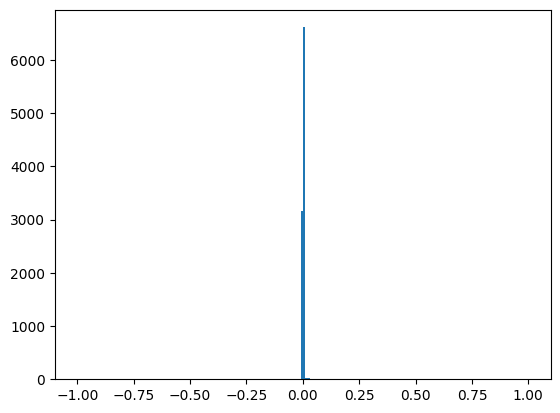



# LHS
LH_ResultsN=pd.DataFrame({'Agent':[],'Value':[],'Consumption':[], 'i_a':[], 'm':[]})
LH_ResultsL=pd.DataFrame({'Agent':[],'Value':[],'Consumption':[], 'i_a':[], 'm':[]})
LH_ResultsH=pd.DataFrame({'Agent':[],'Value':[],'Consumption':[], 'i_a':[], 'm':[]})
for i in range(len(LH_sampledf)):
    info=agent(k=LH_sampledf.loc[i,"k"], θ=LH_sampledf.loc[i,"Theta"], σ=LH_sampledf.loc[i,"Sigma"], α=LH_sampledf.loc[i,"Alpha"],adapt=AdapTableArray)
    feasible=which_bellman(info)
    if len(feasible)>2:
        LH_ResultsH.loc[i]=[f"S{i}",*feasible[2]]
    if len(feasible)>1:
        LH_ResultsL.loc[i]=[f"S{i}",*feasible[1]]
    LH_ResultsN.loc[i]=[f"S{i}",*feasible[0]]
    




# Random

R_ResultsN=pd.DataFrame({'Agent':[],'Value':[],'Consumption':[], 'i_a':[], 'm':[]})
R_ResultsL=pd.DataFrame({'Agent':[],'Value':[],'Consumption':[], 'i_a':[], 'm':[]})
R_ResultsH=pd.DataFrame({'Agent':[],'Value':[],'Consumption':[], 'i_a':[], 'm':[]})
for i in range(len(R_sampledf)):
    info=agent(k=R_sampledf.loc[i,"k"], θ=R_sampledf.loc[i,"Theta"], σ=R_sampledf.loc[i,"Sigma"], α=R_sampledf.loc[i,"Alpha"], adapt=AdapTableArray)
    feasible=which_bellman(info)
    if len(feasible)>2:
        R_ResultsH.loc[i]=[f"S{i}",*feasible[2]]
    if len(feasible)>1:
        R_ResultsL.loc[i]=[f"S{i}",*feasible[1]]
    R_ResultsN.loc[i]=[f"S{i}",*feasible[0]]

In [ ]:
# S_ResultsN.to_csv(f"SaltelliResultsNone.csv")
# S_ResultsL.to_csv(f"SaltelliResultsLow.csv")
# S_ResultsH.to_csv(f"SaltelliResultsHigh.csv")

# LH_ResultsN.to_csv(f"LatinResultsNone.csv")
# LH_ResultsL.to_csv(f"LatinResultsLow.csv")
# LH_ResultsH.to_csv(f"LatinResultsHigh.csv")

# R_ResultsN.to_csv(f"RandomResultsNone.csv")
# R_ResultsL.to_csv(f"RandomResultsLow.csv")
# R_ResultsH.to_csv(f"RandomResultsHigh.csv")

# Create Interpolated Surface (Linear)
print(len(S_sampledf["k"]),len(S_ResultsN["Value"]))
# Saltelli
S_N_Interp_C=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsN["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')
S_N_Interp_V=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsN["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')

S_L_Interp_C=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsL["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')
S_L_Interp_V=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsL["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')

S_H_Interp_C=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsH["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')
S_H_Interp_V=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsH["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')

# LHS
LH_N_Interp=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsN["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')
LH_N_Interp=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsN["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')

LH_L_Interp=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsL["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')
LH_L_Interp=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsL["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')

LH_H_Interp=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsH["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')
LH_H_Interp=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsH["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')


# Both, bc why not?
SLH_N_Interp=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Consumption"],LH_ResultsN["Consumption"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')
SLH_N_Interp=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Value"],LH_ResultsN["Value"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')

SLH_L_Interp=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Consumption"],LH_ResultsN["Consumption"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')
SLH_L_Interp=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Value"],LH_ResultsN["Value"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')

SLH_H_Interp=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Consumption"],LH_ResultsN["Consumption"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')
SLH_H_Interp=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Value"],LH_ResultsN["Value"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='linear')



In [ ]:
# Create Interpolated Surface (Nearest)
print(len(S_sampledf["k"]),len(S_ResultsN["Value"]))
# Saltelli
S_N_Interp_C=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsN["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')
S_N_Interp_V=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsN["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')

S_L_Interp_C=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsL["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')
S_L_Interp_V=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsL["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')

S_H_Interp_C=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsH["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')
S_H_Interp_V=griddata((S_sampledf["k"],S_sampledf["Theta"], S_sampledf["Sigma"],S_sampledf["Alpha"]),S_ResultsH["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')

# LHS
LH_N_Interp_C=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsN["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')
LH_N_Interp_V=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsN["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')

LH_L_Interp_C=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsL["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')
LH_L_Interp_V=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsL["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')

LH_H_Interp_C=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsH["Consumption"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')
LH_H_Interp_V=griddata((LH_sampledf["k"],LH_sampledf["Theta"], LH_sampledf["Sigma"],LH_sampledf["Alpha"]),LH_ResultsH["Value"],(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')


# Both, bc why not?
SLH_N_Interp_C=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Consumption"],LH_ResultsN["Consumption"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')
SLH_N_Interp_V=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Value"],LH_ResultsN["Value"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')

SLH_L_Interp_C=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Consumption"],LH_ResultsN["Consumption"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')
SLH_L_Interp_V=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Value"],LH_ResultsN["Value"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')

SLH_H_Interp_C=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Consumption"],LH_ResultsN["Consumption"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')
SLH_H_Interp_V=griddata((pd.concat([S_sampledf["k"],LH_sampledf["k"]]),pd.concat([S_sampledf["Theta"],LH_sampledf["Theta"]]), pd.concat([S_sampledf["Sigma"],LH_sampledf["Sigma"]]),pd.concat([S_sampledf["Alpha"],LH_sampledf["Alpha"]])),pd.concat([S_ResultsN["Value"],LH_ResultsN["Value"]]),(R_sampledf["k"],R_sampledf["Theta"], R_sampledf["Sigma"],R_sampledf["Alpha"]), method='nearest')





In [ ]:
import torch
S_Interp_V=torch.stack([torch.tensor(S_N_Interp_V),torch.tensor(S_L_Interp_V),torch.tensor(S_H_Interp_V)], dim=1)
S_Interp_C=torch.stack([torch.tensor(S_N_Interp_C),torch.tensor(S_L_Interp_C),torch.tensor(S_H_Interp_C)], dim=1)
S_Interp_max=torch.max(S_Interp_V,dim=1)

S_consumption=S_Interp_C*torch.nn.functional.one_hot(S_Interp_max[1])
S_consumption=S_consumption.sum(dim=1)

S_adaptation=S_Interp_max[0]

print(S_Interp_V)



In [ ]:
LH_Interp_V=torch.stack([torch.tensor(LH_N_Interp_V),torch.tensor(LH_L_Interp_V),torch.tensor(LH_H_Interp_V)], dim=1)
LH_Interp_C=torch.stack([torch.tensor(LH_N_Interp_C),torch.tensor(LH_L_Interp_C),torch.tensor(LH_H_Interp_C)], dim=1)
LH_Interp_max=torch.max(LH_Interp_V,dim=1)

LH_consumption=LH_Interp_C*torch.nn.functional.one_hot(LH_Interp_max[1])
LH_consumption=LH_consumption.sum(dim=1)

LH_adaptation=LH_Interp_max[0]

In [ ]:
SLH_Interp_V=torch.stack([torch.tensor(SLH_N_Interp_V),torch.tensor(SLH_L_Interp_V),torch.tensor(SLH_H_Interp_V)], dim=1)
SLH_Interp_C=torch.stack([torch.tensor(SLH_N_Interp_C),torch.tensor(SLH_L_Interp_C),torch.tensor(SLH_H_Interp_C)], dim=1)
SLH_Interp_max=torch.max(SLH_Interp_V,dim=1)

SLH_consumption=SLH_Interp_C*torch.nn.functional.one_hot(SLH_Interp_max[1])
SLH_consumption=SLH_consumption.sum(dim=1)

SLH_adaptation=SLH_Interp_max[0]

In [ ]:
# Test Excluded Sample 
import matplotlib.pyplot as plt

plt.scatter(x=R_sampledf.loc[0:99,'k'], y=S_N_Interp, c='blue', s=5, alpha=0.3)
plt.scatter(x=R_sampledf.loc[0:99,'k'], y=R_ResultsN['Consumption'], c='black', s=1)
plt.ylabel("Consumption")
plt.xlabel("k")

plt.show()


plt.scatter(x=R_sampledf.loc[0:99,'k'], y=S_N_Interp, c=range(100), s=7, alpha=0.3)
plt.scatter(x=R_sampledf.loc[0:99,'k'], y=R_ResultsN['Consumption'], c=range(100), s=1)
plt.xlabel("k")
plt.ylabel("Consumption")

plt.show()



MAE=abs(S_N_Interp_C-R_ResultsN['Consumption'])
plt.boxplot(MAE)
plt.ylabel('MAE')
plt.show()

#plt.scatter(x=R_sampledf['k'], y=S_N_Interp, c=R_sampledf['AgentID'], s=5, alpha=0.3)
#plt.scatter(x=R_sampledf['k'], y=R_ResultsN['Consumption'], c=R_sampledf['AgentID'], s=1)

#plt.show()






In [ ]:
print(type(pd.read_csv("SaltelliResultsNone.csv")))
S_None=torch.from_numpy(np.genfromtxt("SaltelliResultsNone.csv", delimiter=","))
S_Low=torch.from_numpy(np.genfromtxt("SaltelliResultsLow.csv", delimiter=","))
S_High=torch.from_numpy(np.genfromtxt("SaltelliResultsHigh.csv", delimiter=","))

In [ ]:
from scipy.optimize import curve_fit

x = S_sampledf['k']
y = S_ResultsN["Consumption"]

def f(x,A):
    return A*np.log(x)+1
    

popt, pcov = curve_fit(f, x, y, method="trf")
y_fit = f(x, *popt)
print(popt)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '.')
plt.show()
